# Tuning the CIB Power Spectra Normalization

In [1]:
import numpy as np
import hmvec as hm
import matplotlib.pyplot as plt
import matplotlib

In [32]:
#Plot settings
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'

## Setting Up

In [3]:
#Setup Grid
Nz = 100                                 # num of redshifts
Nm = 100                                 # num of masses
Nk = 1000                                # num of wavenumbers
redshifts = np.linspace(0.01, 6, Nz)             
masses = np.geomspace(1.0e6, 1.0e15, Nm)          
ks = np.geomspace(1.0e-3, 100.0, Nk)              # wavenumbers

#Setup ells to Evaluate Cell at
lowell = 10
highell = 3000
ellstep = 15
ells = np.arange(lowell, highell, ellstep)
Nell = len(ells)

#Initialize Halo Model 
hcos = hm.HaloModel(redshifts, ks, ms=masses)

In [15]:
#Set the Normalization
Lo = 5e-8

#Set CIB Parameters
hcos.set_cibParams('planck13', L_o = Lo)

In [16]:
#Data/Freqs to Cross Correlate
filenames = ['data/cibplanck_3000.txt','data/cibplanck_545.txt','data/cibplanck_217.txt']
frequencies = np.array([3000, 545, 217])*1e9    #These must go from high to low!
# filenames = ['data/cibplanck_3000.txt','data/cibplanck_857.txt','data/cibplanck_545.txt','data/cibplanck_353.txt','data/cibplanck_217.txt','data/cibplanck_143.txt']
# frequencies = np.array([3000, 857, 545, 353, 217, 143])*1e9
Nfreq = len(frequencies)
Nfiles = len(filenames)

## Calculate the Power Spectra

In [25]:
#Initializations
Cs = np.zeros((Nfreq, Nfiles, len(ells)))
C_1hs = np.zeros((Nfreq, Nfiles, len(ells)))
C_2hs = np.zeros((Nfreq, Nfiles, len(ells)))

#Calculations
for i, f1 in enumerate(frequencies):
    for j, f2 in enumerate(frequencies):
        freqarray = np.array([[f1],[f2]], dtype=np.double)  
        
        #Get 3D Power Spectra P(z,k): Jiang
        Pjj_tot = hcos.get_power("cib", "cib", nu_obs=freqarray, satmf = 'jiang')
        Pjj_1h = hcos.get_power_1halo("cib", "cib", nu_obs=freqarray, satmf = 'jiang')  
        Pjj_2h = hcos.get_power_2halo("cib", "cib", nu_obs=freqarray, satmf = 'jiang')  

        #Limber Integrals: Jiang
        Cs[j,i] = hcos.C_ii(ells, redshifts, ks, Pjj_tot, dcdzflag=False)      
        C_1hs[j,i] = hcos.C_ii(ells, redshifts, ks, Pjj_1h, dcdzflag=False)
        C_2hs[j,i] = hcos.C_ii(ells, redshifts, ks, Pjj_2h, dcdzflag=False)

## Plot Everything

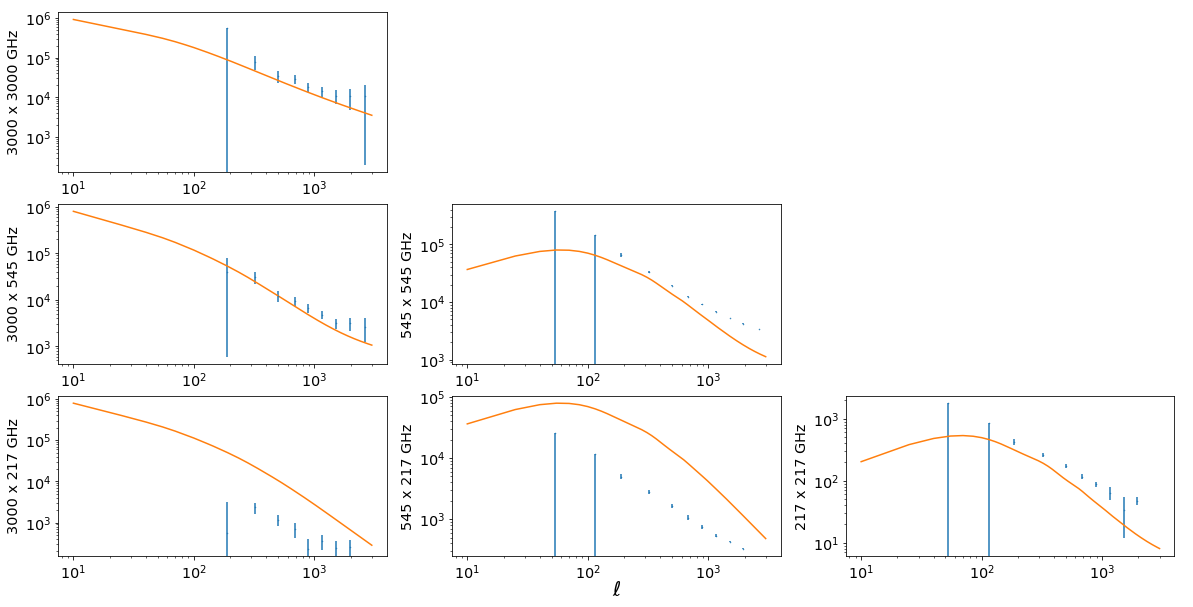

In [35]:
#Set the Figure
fig, ax = plt.subplots(Nfreq, Nfiles, figsize=(20, 10))
# fig, ax = plt.subplots(Nfreq, Nfiles, figsize=(40, 30))

#Read in the Data
for icol, fname in enumerate(filenames):
    ells_data = np.loadtxt(fname, usecols=0)
    data = np.loadtxt(fname, usecols=(1, 4, 7, 10, 13, 16))
    err = np.loadtxt(fname, usecols=(2, 5, 8, 11, 14, 17))
    uplim = np.genfromtxt(fname, dtype=bool, usecols=(3, 6, 9, 12, 15, 18))
    
    #Plot
    for irow, freq in enumerate(frequencies):
        #Make it a corner plot
        if (irow < icol) or (irow == 5 and icol == 0):
            ax[irow, icol].axis('off')
            continue
        
        #Connect Column from Data Table to Frequency
        freqdict = {3000e9: 0, 857e9: 1, 545e9: 2, 353e9: 3, 217e9: 4, 143e9: 5}
        idatacol = freqdict[freq]
        
        #Plot the Data
        ax[irow, icol].errorbar(ells_data, data[:,idatacol], yerr=err[:,idatacol], ls='none', marker='.', markersize=1, uplims=uplim[:,idatacol])
        
        #Plot the Cls
        ax[irow, icol].plot(ells, Cs[irow, icol, :])
#         ax[irow, icol].plot(ells, C_1hs[irow, icol, :])
#         ax[irow, icol].plot(ells, C_2hs[irow, icol, :])
        
        #Gravy
        ax[irow, icol].set_xscale('log')
        ax[irow, icol].set_yscale('log')
        ax[irow, icol].set_ylabel(f'{frequencies[icol]/1e9:.0f} x {frequencies[irow]/1e9:.0f} GHz')

#Set Super Axis Titles
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.ylabel(r'$C_\ell$', fontsize=20)
plt.xlabel(r'$\ell$', fontsize=20);

fig.savefig('cibps.png', bbox_inches='tight', dpi=200);